In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'sentiment-analysis-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F989445%2F1808590%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240415%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240415T112902Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D91e6d8c442fbfa6014d0128fae26855c569ea74c691d4184d31b83b35b26926e4b73ff66a39bf10209e1f5a1b5744e0cc4914d703f86364036d68a294acb108b563306b5fc32175d214b185674df3eb284737ff7d6b6054e8f99c371aaaaa6628800ccda8d1f18573eb21b553e7f68de3be96fde7f86f1e577eb2904ad74c59c53cb9318d966b226cb466365b6513125377842007157fad6a9dcdf5e9d98b85bdca0f9522fd5718e5833dd85956159fa512d10d61c05d4757a926b5a1a080ebbb17614ed63c800244452b34b5ae17786e133941cc9381bf0fff46fae0da357caf125d46366fcb869241588b9135183e4d8405fca9a4189e9ca7166ce0a7516a7,twitter-entity-sentiment-analysis:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1520310%2F2510329%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240415%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240415T112903Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D70d579a7f0378dfaaeb579600a08a3c398227c9645a1ea5646f1bdf2d2e72e6f7813ba2c6ebb2fcba6ccedb83509d89a1eea670e7929614029fdd295df5a5e936229db9973ea4f3ad648368d616608c3c5fc5a40ba6a0ac1c80c10b0550239a42cd45fa6176ca9ec85786909ef18cdbd191aeac5d04bba6f0b52efca147dcf28967768b6e0120593c053124a85915694d4cbff4f31a8f03e2e96decce92f20d2e9c6538c87a9b16835491098710a89077e6489844638a3f385006e4cc564cb36fdbc887b48b7158213b1b2d53d6f375671ecca2f4e0424b30c47a1e794f32ad56cc45abf61fb2a39b9a323ddd7aae5a0cb7b4b9ec255de40cbdc565853f3e85d,financial-sentiment-analysis:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1918992%2F3205803%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240415%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240415T112903Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db865537cb86c07a4683f6a7ac787ce38e22a235dfa301dcda0efaec301da2bc936a61e9b5606343ca52c50d5394021b9aab77d45583d16f4aa42cd9c08bd35bbc17d2b2427e267f2f19799b3f85378a63438a9b901d20a22a529196fba295793b45938ec040946834ac22441122b5fb2c3c90e5e7f7e4771266c504995a492bd43ca57f66989fe32ce536a9a340987aacdb047840a42917b34a7335abd3766ee257db100cf1f3e10c4f61b069b17873a6c8cc816f7a4b6405eff1b3b2fdd1aba0af108a4b094845db0f8df5959ffac9ef35c2bc2147abb1cbfafdbb5e2f8ef01260c9fb7851bd299c70ed9d42758f831d8d7414749f19d9260d353cdb2942678'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 57092644 bytes downloaded
Downloaded and uncompressed: sentiment-analysis-dataset
[==================================================] 2090169 bytes downloaded
Downloaded and uncompressed: twitter-entity-sentiment-analysis
[==================================================] 282375 bytes downloaded
Downloaded and uncompressed: financial-sentiment-analysis
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-dataset/test.csv
/kaggle/input/sentiment-analysis-dataset/testdata.manual.2009.06.14.csv
/kaggle/input/sentiment-analysis-dataset/train.csv
/kaggle/input/sentiment-analysis-dataset/training.1600000.processed.noemoticon.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv
/kaggle/input/financial-sentiment-analysis/data.csv


# Prepare Data

## Import Libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, ConfusionMatrixDisplay
import re
import string
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
# Ignore FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

## Read csv files

In [4]:
d = pd.read_csv('/kaggle/input/sentiment-analysis-dataset/train.csv',encoding='latin1');
f = pd.read_csv('/kaggle/input/sentiment-analysis-dataset/test.csv',encoding='latin1');
df = pd.concat([d,f])

## Explore dataset

In [5]:
print(df.shape)
print(df.info())
df.head()

(32296, 10)
<class 'pandas.core.frame.DataFrame'>
Index: 32296 entries, 0 to 4814
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            31015 non-null  object 
 1   text              31014 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         31015 non-null  object 
 4   Time of Tweet     31015 non-null  object 
 5   Age of User       31015 non-null  object 
 6   Country           31015 non-null  object 
 7   Population -2020  31015 non-null  float64
 8   Land Area (Km²)   31015 non-null  float64
 9   Density (P/Km²)   31015 non-null  float64
dtypes: float64(3), object(7)
memory usage: 2.7+ MB
None


,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797.0,27400.0,105.0
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265.0,470.0,164.0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272.0,1246700.0,26.0


## Convert Data

In [6]:
df.dropna(inplace=True)

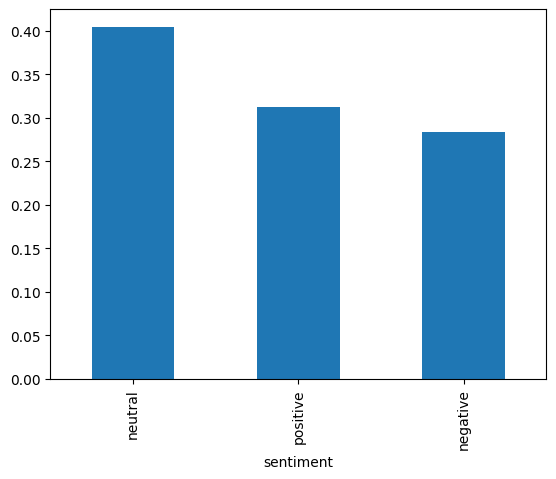

In [7]:
df['sentiment'].value_counts(normalize=True).plot(kind='bar');

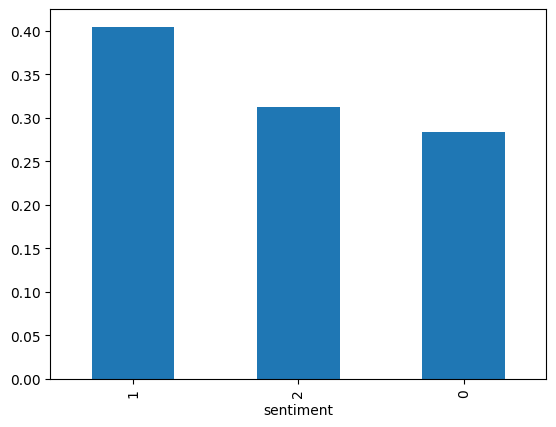

In [8]:
# Convert sentiment column to categorical variable
df['sentiment'] = df['sentiment'].astype('category').cat.codes
df['sentiment'].value_counts(normalize=True).plot(kind='bar');

In [9]:
# Convert Time of Tweet column to categorical variable
df['Time of Tweet'] = df['Time of Tweet'].astype('category').cat.codes
# Convert Country column to categorical variable
df['Country'] = df['Country'].astype('category').cat.codes
# convert Age of User to integer
df['Age of User']=df['Age of User'].replace({'0-20':18,'21-30':25,'31-45':38,'46-60':53,'60-70':65,'70-100':80})

## Drop unuseful data

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27480 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27480 non-null  int8   
 4   Time of Tweet     27480 non-null  int8   
 5   Age of User       27480 non-null  int64  
 6   Country           27480 non-null  int16  
 7   Population -2020  27480 non-null  float64
 8   Land Area (Km²)   27480 non-null  float64
 9   Density (P/Km²)   27480 non-null  float64
dtypes: float64(3), int16(1), int64(1), int8(2), object(3)
memory usage: 1.8+ MB


In [11]:
df.drop(columns=['textID','Time of Tweet', 'Age of User', 'Country', 'Population -2020', 'Land Area (Km²)', 'Density (P/Km²)'])

,text,selected_text,sentiment
0,"I`d have responded, if I were going","I`d have responded, if I were going",1
1,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,0
2,my boss is bullying me...,bullying me,0
3,what interview! leave me alone,leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",0
...,...,...,...
27476,wish we could come see u on Denver husband l...,d lost,0
27477,I`ve wondered about rake to. The client has ...,", don`t force",0
27478,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,2
27479,But it was worth it ****.,But it was worth it ****.,2


## Creat a function to process text

In [12]:
def wp(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [13]:
df['selected_text'] = df["selected_text"].apply(wp)

## Split data

In [14]:
X=df['selected_text']
y= df['sentiment']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(21984,)
(5496,)
(21984,)
(5496,)


## Convert text to vectors

In [16]:
vectorization = TfidfVectorizer()
XV_train = vectorization.fit_transform(X_train)
XV_test = vectorization.transform(X_test)

## Baseline model

In [17]:
score_baseline = df['sentiment'].value_counts(normalize=True).max()
score_baseline

0.40454876273653567

## Logistic regression

In [18]:
lr = LogisticRegression(n_jobs=-1)
lr.fit(XV_train,y_train)

LogisticRegression(n_jobs=-1)

In [19]:
pred_lr=lr.predict(XV_test)

In [20]:
# get accuracy score
score_lr = accuracy_score(y_test, pred_lr)
score_lr

0.8309679767103348

In [21]:
print(classification_report(y_test, pred_lr))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1572
           1       0.79      0.88      0.84      2236
           2       0.91      0.81      0.85      1688

    accuracy                           0.83      5496
   macro avg       0.84      0.82      0.83      5496
weighted avg       0.84      0.83      0.83      5496



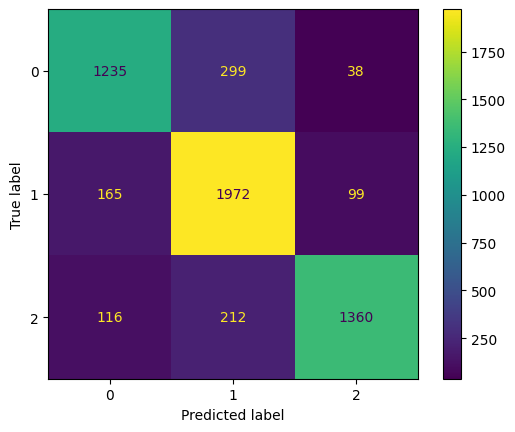

In [22]:
ConfusionMatrixDisplay.from_predictions(y_test, pred_lr);

## Decision Tree Classification

In [23]:
dt = DecisionTreeClassifier()
dt.fit(XV_train, y_train)

DecisionTreeClassifier()

In [24]:
pred_dt = dt.predict(XV_test)

In [25]:
score_dt = dt.score(XV_test, y_test)
score_dt

0.763646288209607

In [26]:
print(classification_report(y_test, pred_dt))

              precision    recall  f1-score   support

           0       0.70      0.75      0.72      1572
           1       0.76      0.78      0.77      2236
           2       0.83      0.76      0.79      1688

    accuracy                           0.76      5496
   macro avg       0.77      0.76      0.76      5496
weighted avg       0.77      0.76      0.76      5496



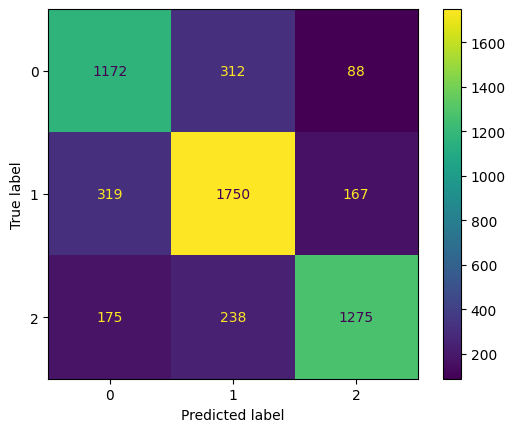

In [27]:
ConfusionMatrixDisplay.from_predictions(y_test, pred_dt);

## Random Forest Classifier

In [28]:
rfc = RandomForestClassifier(random_state=0)
rfc.fit(XV_train, y_train)

RandomForestClassifier(random_state=0)

In [29]:
pred_rfc = rfc.predict(XV_test)

In [30]:
score_rfc = rfc.score(XV_test, y_test)
score_rfc

0.8138646288209607

In [31]:
print(classification_report(y_test, pred_rfc))

              precision    recall  f1-score   support

           0       0.79      0.76      0.77      1572
           1       0.77      0.90      0.83      2236
           2       0.92      0.76      0.83      1688

    accuracy                           0.81      5496
   macro avg       0.83      0.80      0.81      5496
weighted avg       0.82      0.81      0.81      5496



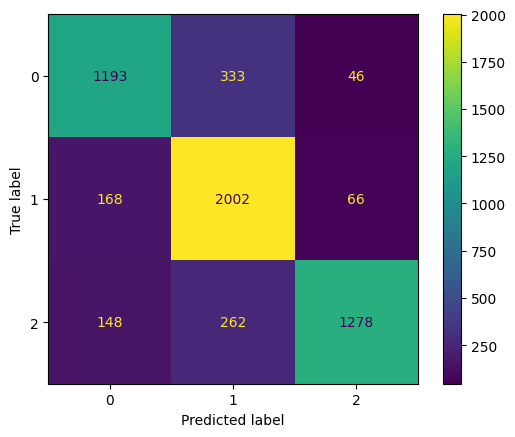

In [32]:
ConfusionMatrixDisplay.from_predictions(y_test, pred_rfc);

## Best model in accuracy

In [33]:
print(f'Baseline model:{score_baseline} \nLogistic regression {score_lr}\nDecision Tree Classification {score_dt}\nRandim Forest Classifier {score_rfc}')

Baseline model:0.40454876273653567 
Logistic regression 0.8309679767103348
Decision Tree Classification 0.763646288209607
Randim Forest Classifier 0.8138646288209607


# Communicate the result

In [34]:
def output_lable(n):
    if n == 0:
        return "The Text Sentement is Negative"
    elif n == 1:
        return "The Text Sentement is Neutral"
    elif n == 2:
        return "The Text Sentement is Positive"

def manual_testing(news):
    testing_news = {"text":[news]}
    new_def_test = pd.DataFrame(testing_news)
    new_def_test["text"] = new_def_test["text"].apply(wp)
    new_x_test = new_def_test["text"]
    new_xv_test = vectorization.transform(new_x_test)
    pred_lr = lr.predict(new_xv_test)
    pred_dt = dt.predict(new_xv_test)
    pred_rfc = rfc.predict(new_xv_test)

    return print((output_lable(pred_lr[0])))

In [35]:
# enter a text to find if its sentiment
text = "Iam Sad"
manual_testing(text)

The Text Sentement is Negative
